# Download New Yorker cartoons

We'll be scraping images and captions from their [Random cartoon page](https://www.newyorker.com/cartoons/random/).

In [17]:
import requests
from requests.exceptions import Timeout
import urllib.request
import html
import time
import json

## Write a class to handle the GET requests to NewYorker.com

In [27]:
class Scraper(object):
    """Scrape cartoons from The New Yorker random cartoon page"""

    # Create a persistent requests connection
    _session = requests.Session()
    _session.headers = {'application': 'PyYorker',
                        'If-None-Match': None,
                        'Accept': '*/*',
                        'Accept-Encoding': 'gzip, deflate, br',
                        'Connection': 'keep-alive',
                        'DNT': '1',
                        'Host': 'www.newyorker.com',
                        'Referer': 'https://www.newyorker.com/cartoons/random/',
                        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}
    _SLEEP_MIN = 0.2  # Enforce minimum wait time between API calls (seconds)

    def __init__(self, timeout=5, sleep_time=0.5):
        """ Scraper Constructor

        :param timeout: time before quitting on response (seconds)
        :param sleep_time: time to wait between requests
        """

        self.api_root = "https://www.newyorker.com"
        self.timeout = timeout
        self.sleep_time = sleep_time

    def _make_request(self, path):
        """Make a request to the API"""
        uri = self.api_root + path
        
        # Make the request
        response = None
        try:
            response = self._session.request("GET", uri, timeout=self.timeout)
            self._session.headers['If-None-Match'] = response.headers['ETag']
        except Timeout as e:
            print("Timeout raised and caught:\n{e}".format(e=e))

        # Enforce rate limiting
        time.sleep(max(self._SLEEP_MIN, self.sleep_time))
        return response

    def get_random_cartoon(self):
        """Requests a random New Yorker cartoon"""
        endpoint = "/cartoons/random/randomAPI"
        return self._make_request(endpoint)
    
    def download_image(self, response):
        """Saves image to local directory from a URL"""
        fn = f"{response['id']}.{response['src'].split('.')[-1]}"
        urllib.request.urlretrieve(response['src'], f"./images/{fn}")
        time.sleep(1)
        return None

    def format_cartoon_response(self, response):
        """Cleans up the cartoon response data"""
        data = response.json()
        for cartoon in data:
            cartoon['caption_raw'] = cartoon['caption']
            cartoon['caption'] = html.unescape(cartoon['caption_raw'])
        return data
    
    def download_cartoons(self, num_cartoons):
        """Downloads random cartoons from The New Yorker"""
        t0 = time.time()
        cartoons, errors = [], []
        max_errors = 3
        while (len(cartoons) < num_cartoons) and (len(errors) < max_errors):
            # Make a request to the random cartoon page
            r = self.get_random_cartoon()
            if (not r) and (r.status_code != 200):
                errors.append(r)
                print(f"ERROR: {r.status_code}")
                time.sleep(10)
                continue
                
            # Add cartoon info (captions, URLs, etc.) to list
            formatted = self.format_cartoon_response(r)
            cartoons.extend(formatted)
            
            # Print a status message and save progress
            if len(cartoons) % 10 == 0:
                print(f"({len(cartoons)}): {cartoons[-1]['caption']}")
                # Save the cartoon info locally
                with open("cartoons.json", "w") as outfile:
                    json.dump(cartoons, outfile)

        elapsed = time.time() - t0
        print(f"Time elapsed: {elapsed / 60:.2f} minutes.")                      
        return cartoons, errors

## Test out the scraper

In [28]:
# Create an instance of the cartoon scraper
scraper = Scraper(sleep_time=3)

In [25]:
# Make a single request for a random cartoon
r = scraper.get_random_cartoon()
r

<Response [200]>

In [26]:
scraper.format_cartoon_response(r)[0]

{'id': '2710703',
 'pn': 'a18503',
 'date': '08/15/2014 17:22',
 'src': 'https://www.newyorker.com/wp-content/uploads/2014/08/140825_a18503-600.jpg',
 'caption': "“We'd prefer a beheading, but we've decided to sue you instead.”",
 'cartoon_bank_url': 'http://www.condenaststore.com/-sp/_i12228702_.htm',
 'caption_raw': "&ldquo;We'd prefer a beheading, but we've decided to sue you instead.&rdquo;"}

## Download many cartoons

In [ ]:
cartoons, errors = scraper.download_cartoons(num_cartoons=10_000)
cartoons[-1]

# Read in cartoons as a DataFrame

In [30]:
import pandas as pd

In [31]:
df = pd.read_json("./cartoons.json")
df.drop_duplicates(inplace=True)
df.set_index("id", inplace=True)
print(df.shape)
df.head(3)

(1493, 6)


,caption,caption_raw,cartoon_bank_url,date,pn,src
id,,,,,,
2831481,“Please compliment Stewart on the firewood. He...,&ldquo;Please compliment Stewart on the firewo...,,2014-09-16 14:20:00,aa39,https://www.newyorker.com/wp-content/uploads/1...
1550951,“Russ is the sort of person who never wants to...,&ldquo;Russ is the sort of person who never wa...,,2014-07-14 00:10:00,a18048,https://www.newyorker.com/wp-content/uploads/2...
2922743,,,http://www.condenaststore.com/-sp/_i13010768_.htm,2014-12-05 14:36:00,a18714,https://www.newyorker.com/wp-content/uploads/2...


## Download the cartoon images

In [32]:
import urllib.request

In [ ]:
# Download the image for each cartoon
errors = []
for n, (index, row) in enumerate(df.iterrows()):
    if n % 10 == 0:
        print(f"({n}/{len(df)}): {row.caption}")
    fn = f'{index}.{row.src.split(".")[-1]}'
    try:
        tup = urllib.request.urlretrieve(row.src, f"./images/{fn}")
    except Exception as e:
        print(f"ERROR ({n}/{len(df)}):\n{e}")
        errors.append(e)
        time.sleep(10)        
    if len(errors) > 3:
        break
    time.sleep(3)

## Display the images with their captions

In [42]:
import matplotlib.pyplot as plt

In [48]:
df.iloc[0]

caption             “Please compliment Stewart on the firewood. He...
caption_raw         &ldquo;Please compliment Stewart on the firewo...
cartoon_bank_url                                                     
date                                              2014-09-16 14:20:00
pn                                                               aa39
src                 https://www.newyorker.com/wp-content/uploads/1...
Name: 2831481, dtype: object

In [83]:
def displayCartoon(cartoon, figsize=(8, 8)):
    """Displays an image with caption from a row of the DataFrame"""
    fn = f"./images/{cartoon.name}.{cartoon.src.split('.')[-1]}"
    image = plt.imread(fn)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap='gray')
    ax.set(**{"xticks": [], "yticks": []})
    ax.set_xlabel("\n" + cartoon.caption, fontsize=16)
    plt.show()

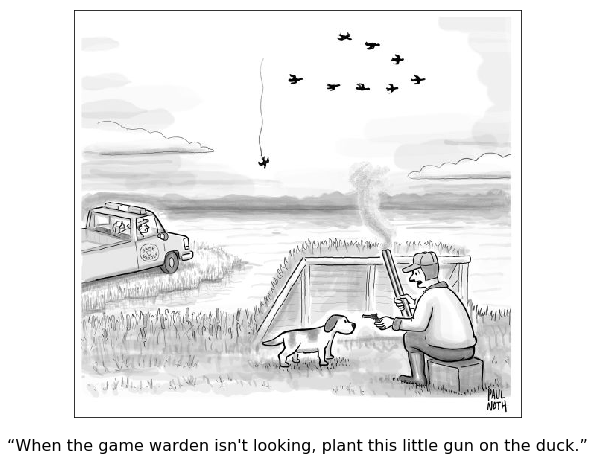

In [84]:
displayCartoon(df.iloc[4])